In [1]:
import psycopg2
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import catboost
import lightgbm
import optuna

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE

from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from optuna.integration import CatBoostPruningCallback, XGBoostPruningCallback, LightGBMPruningCallback


pd.set_option('display.max_columns', None)
random_state = 42

#### Query data from PostgreSQL table, save to csv

In [4]:
conn = psycopg2.connect(host="localhost", dbname='cs', user='postgres', password='123456', port=5432)
cur = conn.cursor()

query = """SELECT * FROM side_dataset where id>=684"""
cur.execute(query)

rows = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(rows, columns=columns)

cur.close()
conn.close()

df.to_csv('df_831.csv')

#### Begin

In [2]:
data = pd.read_csv('df_831.csv')
#First 4 rows are not needed
df = data.iloc[:,5:]

In [3]:
df.head()

,t1_winstreak,t2_winstreak,t1_h2h,t2_h2h,t1_ranking,t2_ranking,t1_pluses,t2_pluses,t1_minuses,t2_minuses,t1_coef,t2_coef,t1_rating,t2_rating,t1_event_rating,t2_event_rating,t1_num_maps,t2_num_maps,t1_avg_lost,t2_avg_lost,t1_avg_won,t2_avg_won,t1_rounds_lost,t1_rounds_won,t1_fp,t1_fp_percent,t1_winrate,t1_played,t1_map_winstreak,t1_map_losestreak,t1_5v4,t1_4v5,t1_pistol,t2_rounds_lost,t2_rounds_won,t2_fp,t2_fp_percent,t2_winrate,t2_played,t2_map_winstreak,t2_map_losestreak,t2_5v4,t2_4v5,t2_pistol,result
0,3.0,0.0,0.0,0.0,15.0,16.0,3.0,1.0,1.0,1.0,1.698462,2.124615,5.53,5.31,5.53,5.31,22.0,42.0,8.21,7.35,11.12,7.00,8.5,0.00,False,0.03,1.00,3.0,0.0,0.0,0.744,0.476,0.667,6.50,4.75,False,0.18,0.50,8.0,0.0,0.0,0.680,0.270,0.438,True
1,0.0,0.0,0.0,0.0,31.0,13.0,0.0,4.0,1.0,0.0,2.754118,1.447059,5.62,5.53,5.62,5.53,11.0,35.0,5.71,7.50,7.25,10.35,9.0,5.00,False,0.07,0.75,4.0,0.0,0.0,0.750,0.378,0.750,7.20,17.33,False,0.21,0.62,8.0,0.0,0.0,0.743,0.330,0.625,True
2,0.0,0.0,0.0,0.0,8.0,118.0,4.0,0.0,0.0,1.0,1.134667,5.431334,5.34,4.97,5.34,4.97,38.0,16.0,6.84,8.62,8.37,10.25,4.0,6.67,False,0.11,0.40,5.0,0.0,0.0,0.702,0.265,0.500,7.00,12.33,False,0.00,0.40,5.0,0.0,0.0,0.737,0.227,0.500,False
3,0.0,0.0,1.0,6.0,48.0,18.0,0.0,3.0,3.0,0.0,2.255294,1.613529,5.08,5.52,5.08,5.52,32.0,62.0,9.65,8.46,9.27,9.48,10.2,17.00,False,0.15,0.71,7.0,0.0,0.0,0.000,0.000,0.000,8.38,11.40,True,0.49,0.57,14.0,0.0,0.0,0.764,0.272,0.500,False
4,0.0,0.0,2.0,0.0,14.0,12.0,3.0,2.0,1.0,1.0,1.320588,3.277647,5.60,4.83,5.60,4.83,31.0,47.0,8.19,8.08,10.90,8.43,10.0,11.50,False,0.18,0.56,9.0,0.0,0.0,0.752,0.310,0.556,8.25,8.00,True,0.27,0.56,9.0,0.0,0.0,0.682,0.278,0.333,True


#### While parsing the data, I was storing this particular stat (average rounds lost(won) on a map) as 0's in case of missing data. So, I convert them to NULL, to deal with them further. Also deleting the rows with incorrect data

In [4]:
df.loc[(df['t1_rounds_lost']>0) & (df['t1_rounds_won'] == 0), 't1_rounds_won'] = None
df.loc[(df['t1_rounds_lost']==0) & (df['t1_rounds_won'] > 0), 't1_rounds_lost'] = None
df.loc[(df['t2_rounds_lost']==0) & (df['t2_rounds_won'] > 0), 't2_rounds_lost'] = None
df.loc[(df['t2_rounds_lost']>0) & (df['t2_rounds_won'] == 0), 't2_rounds_won'] = None

df.drop(df[(df['t2_5v4']==0) & (df['t2_played']>0)].index, axis=0, inplace=True)
df.drop(df[(df['t1_5v4']==0) & (df['t1_played']>0)].index, axis=0, inplace=True)

#### Try filling NULL values with -1's and calues with rounds_lost, rounds_won > 13 to 13

In [5]:
df.loc[df['t1_rounds_lost']>13,'t1_rounds_lost'] = 13
df.loc[df['t2_rounds_lost']>13,'t2_rounds_lost'] = 13
df.loc[df['t1_rounds_won']>13,'t1_rounds_won'] = 13
df.loc[df['t2_rounds_won']>13,'t2_rounds_won'] = 13

df['t1_rounds_lost'].fillna(16, inplace=True)
df['t1_rounds_won'].fillna(16, inplace=True)
df['t2_rounds_lost'].fillna(16, inplace=True)
df['t2_rounds_won'].fillna(16, inplace=True)

In [6]:
df['t1_fp'] = df['t1_fp'].astype('int')
df['t2_fp'] = df['t2_fp'].astype('int')
df['result'] = df['result'].astype('int')

### Final Experiment with final dataset. The differences between team stats + some meaningful stats will be the predicting features, so creating the desired dataset

In [66]:
cols_name = [df.columns[i]+'_dif' for i in range(0,len(df.columns[:22]),2)] + [df.columns[i]+'_dif' for i in range(22, 24)] + [df.columns[i]+'_dif' for i in range(25, 33)]

dataset = pd.DataFrame(columns=cols_name)

for index, name in enumerate(cols_name[:11]):
    dataset[name] = df[df.columns[index*2]] - df[df.columns[index*2+1]]

for index, name in enumerate(cols_name[11:13]):
    dataset[name] = df[df.columns[22+index]] - df[df.columns[33+index]]

for index, name in enumerate(cols_name[13:]):
    dataset[name] = df[df.columns[25+index]] - df[df.columns[36+index]]

dataset['fp_diff'] = df['t1_fp'].astype('int') - df['t2_fp'].astype('int')
dataset['result'] = df['result']
dataset.drop('t1_winstreak_dif', axis=1, inplace=True)

dataset.to_csv('diffs.csv', index=False)

In [7]:
dataset = pd.read_csv('diffs.csv')

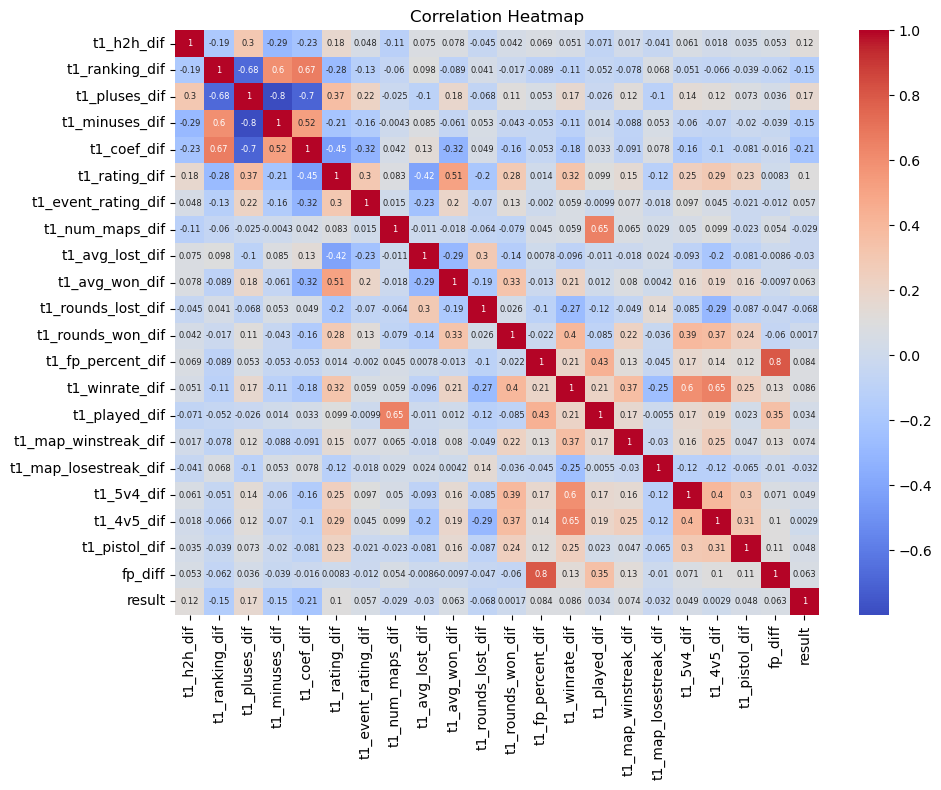

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = dataset.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax, annot_kws={"fontsize": 6})
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [8]:
df.drop(['t1_winstreak', 't2_winstreak', 't1_h2h', 't2_h2h',"t1_rating","t2_rating","t1_event_rating","t2_event_rating","result"], axis=1, inplace=True)
full = pd.concat([df.reset_index(), dataset.reset_index()], axis=1)
full.drop(['index'], axis=1, inplace=True)

In [20]:
full.head(10)

,t1_ranking,t2_ranking,t1_pluses,t2_pluses,t1_minuses,t2_minuses,t1_coef,t2_coef,t1_num_maps,t2_num_maps,t1_avg_lost,t2_avg_lost,t1_avg_won,t2_avg_won,t1_rounds_lost,t1_rounds_won,t1_fp,t1_fp_percent,t1_winrate,t1_played,t1_map_winstreak,t1_map_losestreak,t1_5v4,t1_4v5,t1_pistol,t2_rounds_lost,t2_rounds_won,t2_fp,t2_fp_percent,t2_winrate,t2_played,t2_map_winstreak,t2_map_losestreak,t2_5v4,t2_4v5,t2_pistol,t1_h2h_dif,t1_ranking_dif,t1_pluses_dif,t1_minuses_dif,t1_coef_dif,t1_rating_dif,t1_event_rating_dif,t1_num_maps_dif,t1_avg_lost_dif,t1_avg_won_dif,t1_rounds_lost_dif,t1_rounds_won_dif,t1_fp_percent_dif,t1_winrate_dif,t1_played_dif,t1_map_winstreak_dif,t1_map_losestreak_dif,t1_5v4_dif,t1_4v5_dif,t1_pistol_dif,fp_diff,result
0,15.0,16.0,3.0,1.0,1.0,1.0,1.698462,2.124615,22.0,42.0,8.21,7.35,11.12,7.00,8.50,16.00,0,0.03,1.00,3.0,0.0,0.0,0.744,0.476,0.667,6.50,4.75,0,0.18,0.50,8.0,0.0,0.0,0.680,0.270,0.438,0.0,-1.0,2.0,0.0,-0.426154,0.22,0.22,-20.0,0.86,4.12,2.00,11.25,-0.15,0.50,-5.0,0.0,0.0,0.064,0.206,0.229,0,1
1,31.0,13.0,0.0,4.0,1.0,0.0,2.754118,1.447059,11.0,35.0,5.71,7.50,7.25,10.35,9.00,5.00,0,0.07,0.75,4.0,0.0,0.0,0.750,0.378,0.750,7.20,13.00,0,0.21,0.62,8.0,0.0,0.0,0.743,0.330,0.625,0.0,18.0,-4.0,1.0,1.307059,0.09,0.09,-24.0,-1.79,-3.10,1.80,-8.00,-0.14,0.13,-4.0,0.0,0.0,0.007,0.048,0.125,0,1
2,8.0,118.0,4.0,0.0,0.0,1.0,1.134667,5.431334,38.0,16.0,6.84,8.62,8.37,10.25,4.00,6.67,0,0.11,0.40,5.0,0.0,0.0,0.702,0.265,0.500,7.00,12.33,0,0.00,0.40,5.0,0.0,0.0,0.737,0.227,0.500,0.0,-110.0,4.0,-1.0,-4.296667,0.37,0.37,22.0,-1.78,-1.88,-3.00,-5.66,0.11,0.00,0.0,0.0,0.0,-0.035,0.038,0.000,0,0
3,14.0,12.0,3.0,2.0,1.0,1.0,1.320588,3.277647,31.0,47.0,8.19,8.08,10.90,8.43,10.00,11.50,0,0.18,0.56,9.0,0.0,0.0,0.752,0.310,0.556,8.25,8.00,1,0.27,0.56,9.0,0.0,0.0,0.682,0.278,0.333,2.0,2.0,1.0,0.0,-1.957059,0.77,0.77,-16.0,0.11,2.47,1.75,3.50,-0.09,0.00,0.0,0.0,0.0,0.070,0.032,0.223,-1,1
4,19.0,37.0,3.0,1.0,0.0,2.0,1.447059,2.697647,25.0,61.0,9.50,7.96,6.35,8.86,11.00,8.00,0,0.04,0.25,4.0,0.0,0.0,0.698,0.159,0.375,6.17,8.00,0,0.04,0.75,8.0,0.0,0.0,0.753,0.380,0.562,0.0,-18.0,2.0,-2.0,-1.250588,-0.76,-0.76,-36.0,1.54,-2.51,4.83,0.00,0.00,-0.50,-4.0,0.0,0.0,-0.055,-0.221,-0.187,0,1
5,10.0,21.0,4.0,1.0,1.0,1.0,1.560000,2.433333,33.0,37.0,9.59,7.30,7.31,8.30,11.00,9.00,0,0.23,0.67,9.0,0.0,0.0,0.769,0.284,0.556,5.00,5.00,1,0.34,0.82,11.0,0.0,0.0,0.828,0.351,0.591,-2.0,-11.0,3.0,0.0,-0.873333,-0.45,-0.45,-4.0,2.29,-0.99,6.00,4.00,-0.11,-0.15,-2.0,0.0,0.0,-0.059,-0.067,-0.035,-1,0
6,103.0,4.0,1.0,4.0,1.0,0.0,9.153125,1.043125,38.0,42.0,7.54,8.32,7.71,11.09,7.75,16.00,0,0.15,0.80,5.0,0.0,0.0,0.761,0.389,0.700,8.17,16.00,0,0.22,1.00,6.0,6.0,0.0,0.849,0.296,0.583,0.0,99.0,-3.0,1.0,8.110000,0.01,0.01,-4.0,-0.78,-3.38,-0.42,0.00,-0.07,-0.20,-1.0,-6.0,0.0,-0.088,0.093,0.117,0,0
7,128.0,110.0,0.0,3.0,2.0,0.0,1.917778,1.818889,37.0,27.0,8.33,8.42,8.18,9.73,8.00,8.50,0,0.12,0.33,3.0,0.0,0.0,0.714,0.278,0.500,16.00,11.00,0,0.03,0.00,4.0,0.0,4.0,0.614,0.309,0.500,-1.0,18.0,-3.0,2.0,0.098889,-0.19,0.12,10.0,-0.09,-1.55,-8.00,-2.50,0.09,0.33,-1.0,0.0,-4.0,0.100,-0.031,0.000,0,1
8,128.0,110.0,0.0,3.0,2.0,0.0,1.917778,1.818889,37.0,27.0,8.33,8.42,8.18,9.73,9.33,6.50,0,0.19,0.43,7.0,0.0,0.0,0.754,0.239,0.250,7.80,9.33,0,0.24,0.62,8.0,0.0,0.0,0.747,0.301,0.562,-1.0,18.0,-3.0,2.0,0.098889,-0.19,0.12,10.0,-0.09,-1.55,1.53,-2.83,-0.05,-0.19,-1.0,0.0,0.0,0.007,-0.062,-0.312,0,0
9,128.0,110.0,0.0,3.0,2.0,0.0,1.917778,1.818889,37.0,27.0,8.33,8.42,8.18,9.73,5.50,10.00,0,0.06,0.40,5.0,0.0,0.0,0.615,0.400,0.700,9.00,11.50,0,0.14,0.60,5.0,0.0,0.0,0.717,0.328,0.400,-1.0,18.0,-3.0,2.0,0.098889,-0.19,0.12,10.0,-0.09,-1.55,-3.50,-1.50,-0.08,-0.20,0.0,0.0,0.0,-0.102,0.072,0.300,0,0


#### Preparing data

In [21]:
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('min_max_scaler', MinMaxScaler())
])

columns = full.columns.delete([16,27,57])

pipeline.fit(full.loc[:,columns])
full.loc[:,columns] = pipeline.transform(full.loc[:,columns])

with open('pipeline.pkl','wb') as f:
    pickle.dump(pipeline, f)

full.to_csv('just_scaled.csv', index=False)

In [22]:
full.head()

,t1_ranking,t2_ranking,t1_pluses,t2_pluses,t1_minuses,t2_minuses,t1_coef,t2_coef,t1_num_maps,t2_num_maps,t1_avg_lost,t2_avg_lost,t1_avg_won,t2_avg_won,t1_rounds_lost,t1_rounds_won,t1_fp,t1_fp_percent,t1_winrate,t1_played,t1_map_winstreak,t1_map_losestreak,t1_5v4,t1_4v5,t1_pistol,t2_rounds_lost,t2_rounds_won,t2_fp,t2_fp_percent,t2_winrate,t2_played,t2_map_winstreak,t2_map_losestreak,t2_5v4,t2_4v5,t2_pistol,t1_h2h_dif,t1_ranking_dif,t1_pluses_dif,t1_minuses_dif,t1_coef_dif,t1_rating_dif,t1_event_rating_dif,t1_num_maps_dif,t1_avg_lost_dif,t1_avg_won_dif,t1_rounds_lost_dif,t1_rounds_won_dif,t1_fp_percent_dif,t1_winrate_dif,t1_played_dif,t1_map_winstreak_dif,t1_map_losestreak_dif,t1_5v4_dif,t1_4v5_dif,t1_pistol_dif,fp_diff,result
0,0.078212,0.060241,0.6,0.2,0.333333,0.333333,0.078098,0.097781,0.107438,0.279070,0.434043,0.373134,0.989837,0.130435,0.53125,1.000000,0,0.036585,1.00,0.078947,0.0,0.0,0.744,0.773984,0.667,0.406250,0.296875,0,0.253521,0.50,0.25000,0.0,0.0,0.680,0.308571,0.438,0.523810,0.574144,0.7,0.500000,0.540349,0.642157,0.534667,0.325153,0.612167,1.000000,0.508772,0.908333,0.335616,0.781250,0.431373,0.4375,0.466667,0.558753,0.849035,0.702286,0.5,1
1,0.167598,0.048193,0.0,0.8,0.333333,0.000000,0.199932,0.036565,0.016529,0.224806,0.079433,0.395522,0.203252,0.737319,0.56250,0.312500,0,0.085366,0.75,0.105263,0.0,0.0,0.750,0.614634,0.750,0.450000,0.812500,0,0.295775,0.62,0.25000,0.0,0.0,0.743,0.377143,0.625,0.523810,0.646388,0.1,0.666667,0.628182,0.578431,0.517333,0.300613,0.276299,0.185102,0.501754,0.266667,0.342466,0.588542,0.450980,0.4375,0.466667,0.524580,0.669694,0.642857,0.5,1
2,0.039106,0.469880,0.8,0.0,0.000000,0.333333,0.013030,0.396538,0.239669,0.077519,0.239716,0.562687,0.430894,0.719203,0.25000,0.416875,0,0.134146,0.40,0.131579,0.0,0.0,0.702,0.430894,0.500,0.437500,0.770625,0,0.000000,0.40,0.15625,0.0,0.0,0.737,0.259429,0.500,0.523810,0.159696,0.9,0.333333,0.344204,0.715686,0.554667,0.582822,0.277567,0.322799,0.333333,0.344667,0.513699,0.520833,0.529412,0.4375,0.466667,0.499400,0.658343,0.571429,0.5,0
3,0.072626,0.044177,0.6,0.4,0.333333,0.333333,0.034487,0.201956,0.181818,0.317829,0.431206,0.482090,0.945122,0.389493,0.62500,0.718750,0,0.219512,0.56,0.236842,0.0,0.0,0.752,0.504065,0.556,0.515625,0.500000,1,0.380282,0.56,0.28125,0.0,0.0,0.682,0.317714,0.333,0.619048,0.585551,0.6,0.500000,0.462768,0.911765,0.608000,0.349693,0.517110,0.813770,0.500000,0.650000,0.376712,0.520833,0.529412,0.4375,0.466667,0.562350,0.651532,0.698857,0.0,1
4,0.100559,0.144578,0.6,0.2,0.000000,0.666667,0.049083,0.149554,0.132231,0.426357,0.617021,0.464179,0.020325,0.467391,0.68750,0.500000,0,0.048780,0.25,0.105263,0.0,0.0,0.698,0.258537,0.375,0.385625,0.500000,0,0.056338,0.75,0.25000,0.0,0.0,0.753,0.434286,0.562,0.523810,0.509506,0.7,0.166667,0.498569,0.161765,0.404000,0.226994,0.698352,0.251693,0.608070,0.533333,0.438356,0.260417,0.450980,0.4375,0.466667,0.487410,0.364359,0.464571,0.5,1


In [21]:
dataset = pd.read_csv('just_scaled.csv')
np.random.seed(42)

Y = dataset.loc[:,['result']]
X = dataset.drop('result',axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=127, shuffle=True, random_state=42)
# x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=100, shuffle=True, random_state=42)
print(x_train.shape)
# print(x_val.shape)
print(x_test.shape)

(680, 57)
(127, 57)


#### Batch testing mots of the Sklearn's classification models + Gradient Boosting models with default parameters

In [ ]:
from sklearn import svm, linear_model, neighbors, ensemble, discriminant_analysis, gaussian_process, naive_bayes, model_selection, tree

#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.LogisticRegression(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(), #RandomForest is better
    tree.ExtraTreeClassifier(), #ExtraTrees ensemble is better
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ]

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Test Accuracy Mean']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions


#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    
    cv_results = model_selection.cross_validate(alg, x_train, y_train.values.ravel())

    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    

    #record predictions on the training set to see correlations betweeb model for ensembling
    alg.fit(x_train, y_train.values.ravel())
    
    row_index+=1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

In [10]:
defaults = pd.DataFrame([['XGBoost',0],['CatBoost',0],['LightGBM',0]],columns=['clf_name', 'clf_accuracy'])
models = [XGBClassifier(random_state=random_state), CatBoostClassifier(random_state=random_state, verbose=0), LGBMClassifier(random_state=random_state)]

cv = KFold(n_splits=5)

for index, model in enumerate(models):
    accuracies = []  # List to store the accuracy of each fold
    for train_index, test_index in cv.split(x_train):
        fx_train, fx_test = x_train.iloc[train_index], x_train.iloc[test_index]
        fy_train, fy_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(fx_train, fy_train.values.ravel())

        preds = model.predict(fx_test)

        if index == 1:
            preds = [True if item=='True' else False for item in model.predict(fx_test)]

        accuracies.append(accuracy_score(fy_test, preds))
    
    mean_accuracy = np.mean(accuracies)
    defaults.loc[index, 'clf_accuracy'] = mean_accuracy

defaults.sort_values(by='clf_accuracy', ascending=False).head()

,clf_name,clf_accuracy
2,LightGBM,0.551471
0,XGBoost,0.527941
1,CatBoost,0.486765


#### Finetuning + testing on the test set

##### NaiveBayes

In [29]:
# Define the parameter grids for BernoulliNB and GaussianNB
param_grid_bernoulli = {
    'alpha': [0.01, 0.05 , 0.1, 0.5, 1.0],
    'binarize': [0.0, 0.5, 1.0],
    'fit_prior': [True, False]
}

param_grid_gaussian = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-10]
}

# Create KFold object with 5 folds
kf = KFold(n_splits=5)

# Perform GridSearch for BernoulliNB
grid_search_bernoulli = GridSearchCV(naive_bayes.BernoulliNB(), param_grid_bernoulli, cv=kf)
grid_search_bernoulli.fit(x_train, y_train.values.ravel())

print("Best parameters for BernoulliNB:")
print(grid_search_bernoulli.best_params_)
print("Mean accuracy on test folds for BernoulliNB:")
print(grid_search_bernoulli.best_score_)

# Perform GridSearch for GaussianNB
grid_search_gaussian = GridSearchCV(naive_bayes.GaussianNB(), param_grid_gaussian, cv=kf)
grid_search_gaussian.fit(x_train, y_train.values.ravel())

print("Best parameters for GaussianNB:")
print(grid_search_gaussian.best_params_)
print("Mean accuracy on test folds for GaussianNB:")
print(grid_search_gaussian.best_score_)

Best parameters for BernoulliNB:
{'alpha': 0.01, 'binarize': 0.5, 'fit_prior': False}
Mean accuracy on test folds for BernoulliNB:
0.6014705882352941
Best parameters for GaussianNB:
{'var_smoothing': 1e-09}
Mean accuracy on test folds for GaussianNB:
0.5970588235294118


##### LinearModels

In [46]:
import warnings
warnings.filterwarnings("ignore")

# Define the parameter grid for LogisticRegression
param_grid_logistic = {
    'C': [0.01 ,0.05, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100,200,300],
}

param_grid_logistic_2 = {
    'C': [0.01 ,0.05, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'newton-cholensky', 'sag'],
    'max_iter': [100,200,300],
}

param_grid_logistic_3 = {
    'C': [0.01 ,0.05, 0.1, 1, 10],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'max_iter': [100,200,300],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Define the parameter grid for RidgeClassifierCV
param_grid_ridge = {
    'alphas': [(0.1, 1.0, 10.0)],
    'scoring': ['accuracy'],
    'cv': [5]
}

# Define the parameter grid for LogisticRegressionCV
param_grid_logistic_cv = {
    'Cs': [20, 15, 10],
    'fit_intercept': [True, False],
    'cv': [5],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'newton-cholensky', 'sag'],
    'max_iter': [100,200,300],
}

param_grid_logistic_cv_2 = {
    'Cs': [15, 10, 5, 1.0],
    'fit_intercept': [True, False],
    'cv': [5],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100,200,300],
}

param_grid_logistic_cv_3 = {
    'Cs': [15, 10, 5, 1],
    'fit_intercept': [True, False],
    'cv': [5],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'max_iter': [100,200,300],
    'l1_ratios': [[0.1, 0.3, 0.5, 0.7, 0.9]]
}

# Create KFold object with 5 folds
kf = KFold(n_splits=5)

# Perform GridSearch for LogisticRegression
grid_search_logistic = GridSearchCV(linear_model.LogisticRegression(), param_grid_logistic, cv=kf)
grid_search_logistic.fit(x_train, y_train.values.ravel())

print("Best parameters for LogisticRegression:")
print(grid_search_logistic.best_params_)
print("Mean accuracy on test folds for LogisticRegression:")
print(grid_search_logistic.best_score_)

# Perform GridSearch for RidgeClassifierCV
grid_search_ridge = GridSearchCV(linear_model.RidgeClassifierCV(), param_grid_ridge, cv=kf)
grid_search_ridge.fit(x_train, y_train.values.ravel())

print("Best parameters for RidgeClassifierCV:")
print(grid_search_ridge.best_params_)
print("Mean accuracy on test folds for RidgeClassifierCV:")
print(grid_search_ridge.best_score_)

# Perform GridSearch for LogisticRegressionCV
grid_search_logistic_cv = GridSearchCV(linear_model.LogisticRegressionCV(), param_grid_logistic_cv_3, cv=kf)
grid_search_logistic_cv.fit(x_train, y_train.values.ravel())

print("Best parameters for LogisticRegressionCV:")
print(grid_search_logistic_cv.best_params_)
print("Mean accuracy on test folds for LogisticRegressionCV:")
print(grid_search_logistic_cv.best_score_)

Best parameters for LogisticRegression:
{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Mean accuracy on test folds for LogisticRegression:
0.6029411764705882
Best parameters for RidgeClassifierCV:
{'alphas': (0.1, 1.0, 10.0), 'cv': 5, 'scoring': 'accuracy'}
Mean accuracy on test folds for RidgeClassifierCV:
0.575
Best parameters for LogisticRegressionCV:
{'Cs': 15, 'cv': 5, 'fit_intercept': False, 'l1_ratios': [0.1, 0.3, 0.5, 0.7, 0.9], 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
Mean accuracy on test folds for LogisticRegressionCV:
0.5926470588235294


{'Cs': 15, 'cv': 5, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Mean accuracy on test folds for LogisticRegressionCV:
0.5970588235294116

##### GradientBoostedTrees

In [31]:
def cb_objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 20, step=1),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(
                              **param_grid,
                              iterations=10000,
                              loss_function='Logloss',
                              random_seed=42,
                              early_stopping_rounds=50,
                              eval_metric='Logloss',
                              verbose=0
                              )
 
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

# Threshold Optimization
def find_optimal_threshold(y_true, y_pred_proba, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.0, 1.01, 0.01)
    
    scores = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        score = accuracy_score(y_true, y_pred)
        
        scores.append(score)
    
    best_threshold = thresholds[np.argmax(scores)]
    
    return best_threshold

def optimize_cb(study, X, y, test_x, test_y):
    model = CatBoostClassifier(**study.best_params,
                              iterations=10000,
                              loss_function='Logloss',
                              random_seed=42,
                              early_stopping_rounds=50,
                              eval_metric='Logloss',
                              verbose=0)
    
    cv = KFold(n_splits=5)

    iters = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )

        iters[idx] = model.get_best_iteration()
    
    opt_iters = iters.mean()

    cb_model = CatBoostClassifier(**study.best_params,
                              iterations=round(opt_iters),
                              loss_function='Logloss',
                              random_seed=42,
                              verbose=0)
    
    thresh = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        cb_model.fit(
            X_train,
            y_train
        )

        y_true = y_test
        y_pred_proba = cb_model.predict_proba(X_test)[:,1]

        thresh[idx] = find_optimal_threshold(y_true, y_pred_proba)

    print(thresh)
    best_threshold = thresh.mean()

    cb_model.fit(X,y)
    y_pred_proba = cb_model.predict_proba(test_x)[:,1]
    y_pred = (y_pred_proba >= best_threshold).astype(int)
    best_score = accuracy_score(test_y, y_pred)

    return opt_iters, best_threshold, best_score

# Optuna Study
study = optuna.create_study(direction="minimize", study_name="CB Classifier")
func = lambda trial: cb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

print(optimize_cb(study, x_train, np.ravel(y_train), x_test, y_test))

[0.42 0.49 0.41 0.49 0.44]
(17.4, 0.45, 0.5196850393700787)


In [33]:
def xgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="logloss", verbosity=0, n_jobs=4, random_state=42)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

# Threshold Optimization
def find_optimal_threshold(y_true, y_pred_proba, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.4, 0.61, 0.01)
    
    scores = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        score = accuracy_score(y_true, y_pred)
        
        scores.append(score)

    best_threshold = thresholds[np.argmax(scores)]
    
    return best_threshold

def optimize_xgb(study, X, y, test_x, test_y):
    model = XGBClassifier(**study.best_params, objective='binary:logistic', early_stopping_rounds=50, eval_metric="logloss", verbosity=0, n_jobs=4, random_state=42)
    
    cv = KFold(n_splits=5)

    iters = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )

        iters[idx] = model.best_iteration
    
    opt_iters = iters.mean()

    xgb_model = XGBClassifier(learning_rate= 0.14956095201051628,
                              max_depth= 5,
                              min_child_weight= 0,
                              reg_lambda= 0,
                              reg_alpha= 0,
                              gamma= 9,
                              colsample_bytree= 0.5,
                              subsample= 0.5,
                              objective='binary:logistic', 
                              n_estimators=round(opt_iters), 
                              verbosity=0, 
                              n_jobs=4, 
                              random_state=42)
    
    thresh = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        xgb_model.fit(
            X_train,
            y_train
        )

        y_true = y_test
        y_pred_proba = xgb_model.predict_proba(X_test)[:,1]

        thresh[idx] = find_optimal_threshold(y_true, y_pred_proba)

    print(thresh)
    best_threshold = thresh.mean()

    xgb_model.fit(X,y)
    y_pred_proba = xgb_model.predict_proba(test_x)[:,1]
    y_pred = (y_pred_proba >= best_threshold).astype(int)
    best_score = accuracy_score(test_y, y_pred)

    return opt_iters, best_threshold, best_score

# study = optuna.create_study(direction="minimize", study_name="XGB Classifier")
# func = lambda trial: xgb_objective(trial, x_train, np.ravel(y_train.values))
# study.optimize(func, n_trials=200)

# print(f"\tBest value: {study.best_value:.5f}")
# print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

print(optimize_xgb(study, x_train, np.ravel(y_train), x_test, y_test))

		n_estimators: 10000
		learning_rate: 0.14956095201051628
		max_depth: 5
		min_child_weight: 0
		reg_lambda: 0
		reg_alpha: 0
		gamma: 9
		colsample_bytree: 0.5
		subsample: 0.5
[0.47 0.54 0.46 0.52 0.57]
(16.6, 0.5120000000000001, 0.5275590551181102)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

def lgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="logloss",
            verbose=False
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

# Threshold Optimization
def find_optimal_threshold(y_true, y_pred_proba, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.4, 0.61, 0.01)
    
    scores = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        score = accuracy_score(y_true, y_pred)
        
        scores.append(score)
      
    best_threshold = thresholds[np.argmax(scores)]
    best_score = np.max(scores)
    
    return best_threshold, best_score

def optimize_lgb(study, X, y, test_x, test_y):
    model = LGBMClassifier(objective="binary", **study.best_params, random_state=42, verbosity=-1, early_stopping_rounds=50)
    
    cv = KFold(n_splits=5)

    iters = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="logloss",
            verbose=False
        )

        iters[idx] = model.best_iteration_
    
    opt_iters = iters.mean()

    lgb_model = LGBMClassifier(objective="binary", **study.best_params, random_state=42, verbosity=-1)
    
    lgb_model.fit(X, y, verbose=False)

    y_true = test_y.values.ravel()
    y_pred_proba = lgb_model.predict_proba(test_x)[:,1]
    best_threshold, best_score = find_optimal_threshold(y_true, y_pred_proba)

    return opt_iters, best_threshold, best_score

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

print(optimize_lgb(study, x_train, np.ravel(y_train), x_test, y_test))

### Experiment 2. All features + differences

#### Prepare data

In [6]:
cols_name = [df.columns[i]+'_dif' for i in range(0,len(df.columns[:22]),2)] + [df.columns[i]+'_dif' for i in range(22, 24)] + [df.columns[i]+'_dif' for i in range(25, 33)]

for index, name in enumerate(cols_name[:11]):
    df[name] = df[df.columns[index*2]] - df[df.columns[index*2+1]]

for index, name in enumerate(cols_name[11:13]):
    df[name] = df[df.columns[22+index]] - df[df.columns[33+index]]

for index, name in enumerate(cols_name[13:]):
    df[name] = df[df.columns[25+index]] - df[df.columns[36+index]]

df.to_csv('all+diffs.csv',index=False)

In [18]:
dataset = pd.read_csv('all+diffs.csv')

Y = dataset.loc[:,'result']
X = dataset.drop('result',axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=100, shuffle=True, random_state=42)
print(x_train.shape)
print(x_test.shape)

(519, 65)
(100, 65)


#### Modelling

In [18]:
defaults = pd.DataFrame([['XGBoost',0],['CatBoost',0],['LightGBM',0]],columns=['clf_name', 'clf_accuracy'])
models = [XGBClassifier(random_state=random_state), CatBoostClassifier(random_state=random_state, verbose=0), LGBMClassifier(random_state=random_state)]

cv = KFold(n_splits=5)

for index, model in enumerate(models):
    accuracies = []  # List to store the accuracy of each fold
    for train_index, test_index in cv.split(x_train):
        fx_train, fx_test = x_train.iloc[train_index], x_train.iloc[test_index]
        fy_train, fy_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(fx_train, fy_train.values.ravel())

        preds = model.predict(fx_test)

        if index == 1:
            preds = [True if item=='True' else False for item in model.predict(fx_test)]

        accuracies.append(accuracy_score(fy_test, preds))
    
    mean_accuracy = np.mean(accuracies)
    defaults.loc[index, 'clf_accuracy'] = mean_accuracy

defaults.sort_values(by='clf_accuracy', ascending=False).head()

,clf_name,clf_accuracy
1,CatBoost,0.591561
2,LightGBM,0.549160
0,XGBoost,0.537640


#### Fine-tuning

In [ ]:
#CatBoost
def cb_objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 20, step=1),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(
                              **param_grid,
                              iterations=10000,
                              loss_function='Logloss',
                              random_seed=42,
                              early_stopping_rounds=50,
                              eval_metric='Accuracy',
                              verbose=0
                              )
 
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = [True if item=='True' else False for item in model.predict(X_test)]
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="CB Classifier")
func = lambda trial: cb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value : 0.65902
	Best params:
		learning_rate: 0.05351839411162072
		max_depth: 4
		min_data_in_leaf: 31
		l2_leaf_reg: 3
		colsample_bylevel: 1.0
		subsample: 0.5
		random_strength: 0.8
		bagging_temperature: 10.25

In [ ]:
#XGBoost
def xgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="error", verbosity=0, n_jobs=4, random_state=42)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.64554
	Best params:
		n_estimators: 10000
		learning_rate: 0.060726041010120094
		max_depth: 4
		min_child_weight: 9
		reg_lambda: 2
		reg_alpha: 0
		gamma: 2
		colsample_bytree: 0.6
		subsample: 0.5

In [ ]:
#LGBClassifier
def lgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_error",
            verbose=False
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.62431
	Best params:
		n_estimators: 10000
		learning_rate: 0.09554692701030004
		num_leaves: 2860
		max_depth: 3
		min_data_in_leaf: 9
		lambda_l1: 0
		lambda_l2: 18
		min_gain_to_split: 4.111913891598791
		bagging_fraction: 1.0
		bagging_freq: 15
		feature_fraction: 0.6
		subsample: 1.0

#### Finding optimal number of iterations

In [26]:
# XGBOOST
model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=10000,
		learning_rate=0.060726041010120094,
		max_depth=4,
		min_child_weight=9,
		reg_lambda=2,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.6,
		subsample=0.5,
        early_stopping_rounds=50,
        eval_metric="error",
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.best_iteration

xgb_iters = np.mean(iters)
print(xgb_iters)

28.4


In [27]:
#CatBoost
model = CatBoostClassifier(
        learning_rate= 0.05351839411162072,
		max_depth= 4,
        min_data_in_leaf= 31,
		l2_leaf_reg= 3,
		colsample_bylevel= 1.0,
		subsample= 0.5,
		random_strength= 0.8,
		bagging_temperature= 10.25,
        iterations=10000,
        loss_function='Logloss',
        random_seed=42,
        early_stopping_rounds=50,
        eval_metric='Accuracy',
        verbose=0
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.get_best_iteration()

cb_iters = np.mean(iters)
print(cb_iters)

9.0


In [ ]:
#LGB
model = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        early_stopping_rounds=50,
        n_estimators=10000,
		learning_rate=0.09554692701030004,
		num_leaves=2860,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=18,
		min_gain_to_split=4.111913891598791,
		bagging_fraction=1.0,
		bagging_freq=15,
		feature_fraction=0.6,
		subsample=1.0
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        eval_metric="binary_error",
        verbose=False,
    )
    iters[idx] = model.best_iteration_

lgb_iters = np.mean(iters)
print(lgb_iters)

#### Testing on test set

In [19]:
xgb = XGBClassifier(
        objective='binary:logistic', 
		learning_rate=0.060726041010120094,
		max_depth=4,
		min_child_weight=9,
		reg_lambda=2,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.6,
		subsample=0.5,
        verbosity=0,
        n_jobs=4,
        random_state=42,
        n_estimators=28
    )

xgb.fit(x_train, y_train, verbose=False)
preds = xgb.predict(x_test)
print(accuracy_score(y_test, preds))

0.54


In [20]:
cb = CatBoostClassifier(
        learning_rate= 0.05351839411162072,
		max_depth= 4,
        min_data_in_leaf= 31,
		l2_leaf_reg= 3,
		colsample_bylevel= 1.0,
		subsample= 0.5,
		random_strength= 0.8,
		bagging_temperature= 10.25,
        iterations=9,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
)   

cb.fit(x_train, y_train, verbose=False)
preds = [True if item=='True' else False for item in cb.predict(x_test)]
print(accuracy_score(y_test, preds))

0.52


In [21]:
lgb = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        n_estimators=6,
		learning_rate=0.09554692701030004,
		num_leaves=2860,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=18,
		min_gain_to_split=4.111913891598791,
		bagging_fraction=1.0,
		bagging_freq=15,
		feature_fraction=0.6,
		subsample=1.0
)

lgb.fit(x_train, y_train.values.ravel())
preds = lgb.predict(x_test)
print(accuracy_score(y_test, preds))

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_gain_to_split is set=4.111913891598791, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.111913891598791
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
0.55


#### Feature importance

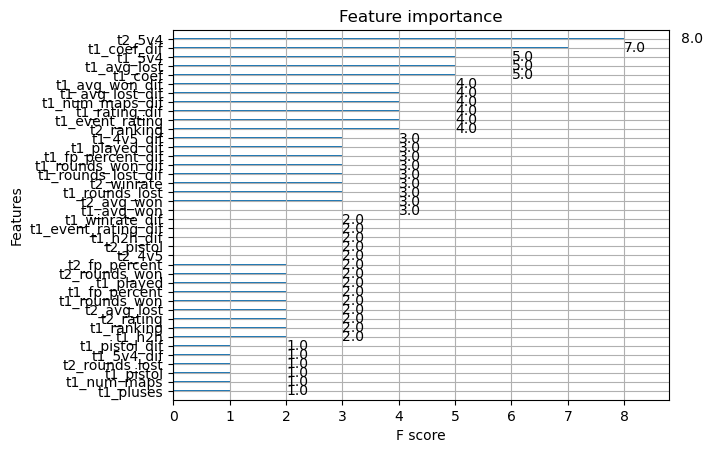

In [26]:
#XGBoost
xgboost.plot_importance(xgb)
plt.show()

In [23]:
#CatBoost
feature_importances = cb.get_feature_importance()
feature_names = cb.feature_names_
importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
print(importances)

[('t1_coef_dif', 14.475957719567893), ('t2_coef', 14.327941603413151), ('t1_avg_lost_dif', 9.736783813390296), ('t1_coef', 7.943344493102026), ('t1_avg_won', 5.216711612633735), ('t1_num_maps', 4.682486149893089), ('t1_winrate_dif', 4.310640657909226), ('t2_event_rating', 4.218671746389398), ('t1_pistol_dif', 3.5370372918602886), ('t2_5v4', 3.314358598796716), ('t2_ranking', 2.7581192884719767), ('t1_fp_percent_dif', 2.736691259357291), ('t2_rounds_won', 2.4251891959319782), ('t1_map_winstreak', 2.420994063317271), ('t2_avg_lost', 2.3247620763989416), ('t1_pluses', 2.2492593106215657), ('t1_map_winstreak_dif', 2.1594757289351016), ('t2_avg_won', 2.0555001163567295), ('t1_event_rating', 1.8079504293468707), ('t2_num_maps', 1.7805307434467084), ('t1_event_rating_dif', 1.7720650211997788), ('t2_played', 1.1888967698705388), ('t1_winrate', 1.0973891607945727), ('t2_pistol', 1.064525401200743), ('t1_pluses_dif', 0.39471774779411495), ('t1_winstreak', 0.0), ('t2_winstreak', 0.0), ('t1_h2h', 

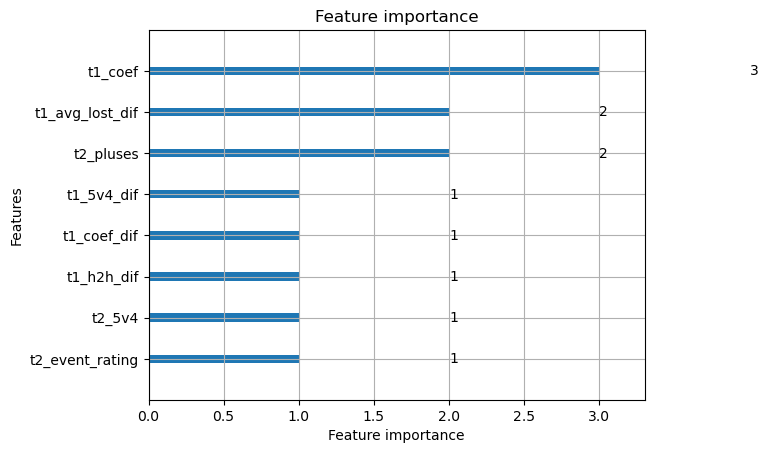

In [24]:
#LightGBM
plot_importance(lgb)
plt.show()

### Experiment 3. Different Data split (Same 100 for test, 10 fold -> 50 for validation) --> No particular effect (Deleted code cells since mainly was just copypasting from previous experiments with minor code changes)

### Experiment 4. Tried to change the eval_metric to logloss --> No particular effect (Deleted code cells since mainly was just copypasting from previous experiments with minor code changes)

### Experiment 5. Feature Selection + experimenting with eval_metric and optuna optimization metric.

#### Select K-best features (k=15)

In [60]:
dataset = pd.read_csv('diffs.csv')
Y = dataset.loc[:,['result']]
X = dataset.drop('result',axis=1)

k_best = SelectKBest(k=15).fit(X,Y.values.ravel())
print(k_best.get_feature_names_out())
X_k = pd.DataFrame(k_best.transform(X), columns=k_best.get_feature_names_out())
print(X_k.shape)

x_train, x_test, y_train, y_test = train_test_split(X_k, Y, test_size=100, shuffle=True, random_state=42)
print(x_train.shape)
print(x_test.shape)

['t1_h2h_dif' 't1_ranking_dif' 't1_pluses_dif' 't1_minuses_dif'
 't1_coef_dif' 't1_rating_dif' 't1_avg_lost_dif' 't1_avg_won_dif'
 't1_rounds_lost_dif' 't1_fp_percent_dif' 't1_winrate_dif' 't1_played_dif'
 't1_map_winstreak_dif' 't1_map_losestreak_dif' 'fp_diff']
(619, 15)
(519, 15)
(100, 15)


##### Modelling

In [61]:
defaults = pd.DataFrame([['XGBoost',0],['CatBoost',0],['LightGBM',0]],columns=['clf_name', 'clf_accuracy'])
models = [XGBClassifier(random_state=random_state), CatBoostClassifier(random_state=random_state, verbose=0), LGBMClassifier(random_state=random_state)]

cv = KFold(n_splits=5)

for index, model in enumerate(models):
    accuracies = []  # List to store the accuracy of each fold
    for train_index, test_index in cv.split(x_train):
        fx_train, fx_test = x_train.iloc[train_index], x_train.iloc[test_index]
        fy_train, fy_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(fx_train, fy_train.values.ravel())

        preds = model.predict(fx_test)

        if index == 1:
            preds = [True if item=='True' else False for item in model.predict(fx_test)]

        accuracies.append(accuracy_score(fy_test, preds))
    
    mean_accuracy = np.mean(accuracies)
    defaults.loc[index, 'clf_accuracy'] = mean_accuracy

defaults.sort_values(by='clf_accuracy', ascending=False).head()

,clf_name,clf_accuracy
1,CatBoost,0.583682
2,LightGBM,0.554892
0,XGBoost,0.543335


##### Fine-tuning

In [ ]:
#CatBoost
def cb_objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 20, step=1),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(
                              **param_grid,
                              iterations=10000,
                              loss_function='Logloss',
                              random_seed=42,
                              early_stopping_rounds=50,
                              eval_metric='Logloss',
                              verbose=0
                              )
 
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="CB Classifier")
func = lambda trial: cb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
#XGBoost
def xgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="logloss", verbosity=0, n_jobs=4, random_state=42)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
#LGBClassifier
def lgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="logloss",
            verbose=False
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

##### Finding optimal iterations and testing on test set

In [75]:
#CatBoost
model = CatBoostClassifier(
        learning_rate= 0.17150150582778445,
		max_depth= 3,
        min_data_in_leaf= 29,
		l2_leaf_reg= 17,
		colsample_bylevel= 0.9,
		subsample= 0.7,
		random_strength= 1.0,
		bagging_temperature= 19.5,
        iterations=10000,
        loss_function='Logloss',
        random_seed=42,
        early_stopping_rounds=50,
        eval_metric='Logloss',
        verbose=0
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.get_best_iteration()

cb_iters = np.mean(iters)
print(cb_iters)

32.4


In [76]:
# XGBOOST
model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=10000,
		learning_rate=0.07209567459064384,
		max_depth=3,
		min_child_weight=2,
		reg_lambda=20,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.7,
		subsample=0.7,
        early_stopping_rounds=50,
        eval_metric="logloss",
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.best_iteration

xgb_iters = np.mean(iters)
print(xgb_iters)

81.0


In [ ]:
#LGB
model = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        early_stopping_rounds=50,
        n_estimators=10000,
		learning_rate=0.0623685938954552,
		num_leaves=900,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=15,
		min_gain_to_split=0.9966877386609001,
		bagging_fraction=0.9,
		bagging_freq=30,
		feature_fraction=0.7,
		subsample=0.7
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        eval_metric="logloss",
        verbose=False,
    )
    iters[idx] = model.best_iteration_

lgb_iters = np.mean(iters)
print(lgb_iters)

In [78]:
xgb = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=81,
		learning_rate=0.07209567459064384,
		max_depth=3,
		min_child_weight=2,
		reg_lambda=20,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.7,
		subsample=0.7,
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

xgb.fit(x_train, y_train, verbose=False)
preds = xgb.predict(x_test)
print(accuracy_score(y_test, preds))

0.52


In [79]:
cb = CatBoostClassifier(
        learning_rate= 0.17150150582778445,
		max_depth= 3,
        min_data_in_leaf= 29,
		l2_leaf_reg= 17,
		colsample_bylevel= 0.9,
		subsample= 0.7,
		random_strength= 1.0,
		bagging_temperature= 19.5,
        iterations=32,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
)   

cb.fit(x_train, y_train, verbose=False)
preds = [True if item=='True' else False for item in cb.predict(x_test)]
print(accuracy_score(y_test, preds))

0.54


In [80]:
lgb = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        n_estimators=52,
		learning_rate=0.0623685938954552,
		num_leaves=900,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=15,
		min_gain_to_split=0.9966877386609001,
		bagging_fraction=0.9,
		bagging_freq=30,
		feature_fraction=0.7,
		subsample=0.7
)

lgb.fit(x_train, y_train.values.ravel())
preds = lgb.predict(x_test)
print(accuracy_score(y_test, preds))

0.56


#### Recursive Feature Selection

##### Find best number of features for base models

In [48]:
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('diffs.csv')
Y = dataset.loc[:,['result']]
X = dataset.drop('result',axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=80, shuffle=True, random_state=42)
# x_train, x_rest, y_train, y_rest = train_test_split(X, Y, test_size=160, shuffle=True, random_state=42)
# x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=80, shuffle=True, random_state=42)

xgb = XGBClassifier(
        objective='binary:logistic', 
        random_state=42
    )

cb = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)

lgb = LGBMClassifier(
    objective='binary',
    random_state=42,
    verbosity=-1
)
# Select bset # of features

features ={}
for i in range(1,23):
    rfe = RFE(estimator=xgb, n_features_to_select=i)
    rfe.fit(x_train, y_train)
    # print(f'The selected features are: {rfe.get_feature_names_out()}')
    rfe_train = rfe.transform(x_train)
    rfe_test = rfe.transform(x_test)

    xgb.fit(rfe_train, y_train)
    features[i] = accuracy_score(y_test,xgb.predict(rfe_test))

print(f"RFE for xgboost {features}")

####

features ={}
for i in range(1,23):
    rfe = RFE(estimator=cb, n_features_to_select=i)
    rfe.fit(x_train, y_train)
    # print(f'The selected features are: {rfe.get_feature_names_out()}')
    rfe_train = rfe.transform(x_train)
    rfe_test = rfe.transform(x_test)

    cb.fit(rfe_train, y_train)
    features[i] = accuracy_score(y_test,[True if item=="True" else False for item in cb.predict(rfe_test)])

print(f"RFE for catboost {features}")

####

features ={}
for i in range(1,23):
    rfe = RFE(estimator=lgb, n_features_to_select=i)
    rfe.fit(x_train, y_train)
    # print(f'The selected features are: {rfe.get_feature_names_out()}')
    rfe_train = rfe.transform(x_train)
    rfe_test = rfe.transform(x_test)

    lgb.fit(rfe_train, y_train)
    features[i] = accuracy_score(y_test,lgb.predict(rfe_test))

print(f"RFE for lgbm {features}")

########################################################################################

RFE for xgboost {1: 0.5125, 2: 0.5, 3: 0.4625, 4: 0.4625, 5: 0.4625, 6: 0.475, 7: 0.5, 8: 0.575, 9: 0.6, 10: 0.525, 11: 0.525, 12: 0.5625, 13: 0.6375, 14: 0.6, 15: 0.575, 16: 0.55, 17: 0.6125, 18: 0.5625, 19: 0.6, 20: 0.65, 21: 0.5875, 22: 0.5625}
RFE for catboost {1: 0.525, 2: 0.525, 3: 0.55, 4: 0.5375, 5: 0.5, 6: 0.5375, 7: 0.575, 8: 0.525, 9: 0.4875, 10: 0.5125, 11: 0.5, 12: 0.5125, 13: 0.525, 14: 0.5125, 15: 0.5375, 16: 0.5375, 17: 0.55, 18: 0.55, 19: 0.5625, 20: 0.575, 21: 0.5625, 22: 0.5625}
RFE for lgbm {1: 0.55, 2: 0.55, 3: 0.475, 4: 0.6125, 5: 0.575, 6: 0.6, 7: 0.5875, 8: 0.5875, 9: 0.6, 10: 0.6125, 11: 0.6125, 12: 0.5375, 13: 0.5625, 14: 0.5625, 15: 0.55, 16: 0.575, 17: 0.5625, 18: 0.575, 19: 0.6, 20: 0.5625, 21: 0.575, 22: 0.575}


In [16]:
with open('rfe_xgb.pkl', 'rb') as file:
    xgb_rfe = pickle.load(file)
with open('rfe_cb.pkl', 'rb') as file:
    cb_rfe = pickle.load(file)
with open('rfe_lgb.pkl', 'rb') as file:
    lgb_rfe = pickle.load(file)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y_train = train.loc[:,'result']
x_train = train.drop('result', axis=1)

y_test = test.loc[:,'result']
x_test = test.drop('result', axis=1)

xgb_train = xgb_rfe.transform(x_train)
xgb_test = xgb_rfe.transform(x_test)
cb_train = cb_rfe.transform(x_train)
cb_test = cb_rfe.transform(x_test)
lgb_train = lgb_rfe.transform(x_train)
lgb_test = lgb_rfe.transform(x_test)

##### Fine-tuning with rfe features

In [ ]:
#fine-tuning for test test
def xgb_objective(trial, x_train, y_train, x_test, y_test):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        # "colsample_bytree": trial.suggest_float(
        #     "colsample_bytree", 0.5, 1, step=0.1
        # ),
        # "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1)
    }

    
    model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="error", verbosity=0, n_jobs=4, random_state=42)
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_test, y_test)],
        verbose=False
    )
    preds = model.predict(x_test)

    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, xgb_train, np.ravel(y_train.values), xgb_test, np.ravel(y_test.values))
study.optimize(func, n_trials=300)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.73750
	Best params:
		n_estimators: 10000
		learning_rate: 0.1778979947018614
		max_depth: 5
		min_child_weight: 2
		reg_lambda: 8
		reg_alpha: 0
		gamma: 0

In [ ]:
#CatBoost
def cb_objective(trial, x_train, y_train, x_val, y_val):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 30, step=1),
        # "colsample_bylevel": trial.suggest_float(
        #     "colsample_bylevel", 0.5, 1, step=0.1
        # ),
        # "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    # pruning = CatBoostPruningCallback(trial, 'Logloss')
    model = CatBoostClassifier(
                            **param_grid,
                            iterations=10000,
                            random_seed=42,
                            verbose=0,
                            eval_metric='Accuracy',
                            early_stopping_rounds=50
                            )

    model.fit(
        x_train,
        y_train,
        eval_set=[(x_val,y_val)],
        verbose=False,
        # callbacks=[pruning]
    )
    preds = [True if item=='True' else False for item in model.predict(x_val)]
    score = accuracy_score(y_val, preds)

    return score

study = optuna.create_study(direction="maximize", study_name="CB Classifier") # pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
func = lambda trial: cb_objective(trial, cb_train, np.ravel(y_train.values), cb_test, np.ravel(y_test.values))
study.optimize(func, n_trials=300)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value : 0.75000
	Best params:
		learning_rate: 0.2504595028727598
		max_depth: 8
		min_data_in_leaf: 46
		l2_leaf_reg: 10
		random_strength: 0.30000000000000004
		bagging_temperature: 8.0

In [ ]:
def lgb_objective(trial, x_train, y_train, x_val, y_val):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float(
        #     "bagging_fraction", 0.5, 1, step=0.1
        # ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        # "feature_fraction": trial.suggest_float(
        #     "feature_fraction", 0.5, 1, step=0.1
        # ),
        # "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1)
    }

    model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_val, y_val)],
        eval_metric="binary_error",
        verbose=False
    )
    preds = model.predict(x_val)
    score = accuracy_score(y_val, preds)

    return score

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, lgb_train, np.ravel(y_train.values), lgb_test, np.ravel(y_test))
study.optimize(func, n_trials=300)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.61250
	Best params:
		n_estimators: 10000
		learning_rate: 0.20757562320258496
		num_leaves: 460
		max_depth: 9
		min_data_in_leaf: 36
		lambda_l1: 17
		lambda_l2: 0
		min_gain_to_split: 9.612828269699992

##### Saving best models

In [34]:
# XGBOOST
model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators= 10000,
		learning_rate= 0.1778979947018614,
		max_depth= 5,
		min_child_weight=2,
		reg_lambda= 8,
		reg_alpha= 0,
		gamma= 0,
		# colsample_bytree= 0.5,
		# subsample= 0.6,
        early_stopping_rounds=50,
        eval_metric="error",
        verbosity=0,
        n_jobs=4,
        random_state=42
    )


model.fit(
    xgb_train,
    y_train,
    eval_set=[(xgb_test, y_test)],
    verbose=False,
)

print(accuracy_score(y_test, model.predict(xgb_test)))

with open('xgb_rfe20.pkl','wb') as file:
    pickle.dump(model, file)

0.7375


In [37]:
# CatBOOST
cb = CatBoostClassifier(
        learning_rate= 0.2504595028727598,
		max_depth= 8,
		l2_leaf_reg= 10,
        min_data_in_leaf=46,
		random_strength= 0.30000000000000004,
		bagging_temperature= 8.0,
        iterations=10000,
        random_seed=42,
        verbose=0,
        eval_metric='Accuracy',
        early_stopping_rounds=50
)   

cb.fit(cb_train, 
       y_train,
       eval_set=[(cb_test, y_test)],
       verbose=False
       )

preds = [True if item=='True' else False for item in cb.predict(cb_test)]
print(accuracy_score(y_test, preds))

with open('cb_rfe20.pkl','wb') as file:
    pickle.dump(cb, file)

0.75


In [ ]:
# LighGBM
lgb = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        n_estimators=10000,
		learning_rate=0.20757562320258496,
		num_leaves=460,
		max_depth=9,
		min_data_in_leaf=36,
		lambda_l1=17,
		lambda_l2=0,
		min_gain_to_split=9.612828269699992,
        early_stopping_rounds=50
)

lgb.fit(lgb_train,
        y_train.values.ravel(),
        eval_set=[(lgb_test, y_test.values.ravel())],
        eval_metric="binary_error",
        verbose=False)

preds = lgb.predict(lgb_test)
print(accuracy_score(y_test, preds))

with open('lgb_rfe20.pkl','wb') as file:
    pickle.dump(lgb, file)

#### PCA

In [17]:
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y_train = train.loc[:,'result']
x_train = train.drop('result', axis=1)

y_test = test.loc[:,'result']
x_test = test.drop('result', axis=1)

xgb = XGBClassifier(
        objective='binary:logistic', 
        random_state=42
    )

cb = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)

lgb = LGBMClassifier(
    objective='binary',
    random_state=42,
    verbosity=-1
)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

features = {}

for i in range(1,23):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    xgb.fit(pca_train, y_train)
    features[i] = accuracy_score(y_test,xgb.predict(pca_test))

print(f"PCA for xgboost {features}")

features = {}
for i in range(1,23):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    cb.fit(pca_train, y_train)
    features[i] = accuracy_score(y_test,[True if item=="True" else False for item in cb.predict(pca_test)])

print(f"PCA for cboost {features}")

features = {}
for i in range(1,23):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    lgb.fit(pca_train, y_train)
    features[i] = accuracy_score(y_test,lgb.predict(pca_test))

print(f"PCA for lgboost {features}")

PCA for xgboost {1: 0.5125, 2: 0.5, 3: 0.5, 4: 0.5375, 5: 0.4875, 6: 0.475, 7: 0.575, 8: 0.5125, 9: 0.5125, 10: 0.525, 11: 0.5125, 12: 0.4875, 13: 0.5625, 14: 0.5125, 15: 0.5, 16: 0.5375, 17: 0.5125, 18: 0.4875, 19: 0.5375, 20: 0.5625, 21: 0.5625, 22: 0.6125}
PCA for cboost {1: 0.5375, 2: 0.4625, 3: 0.45, 4: 0.5375, 5: 0.5125, 6: 0.5, 7: 0.5125, 8: 0.5125, 9: 0.4875, 10: 0.5375, 11: 0.525, 12: 0.5375, 13: 0.5375, 14: 0.5125, 15: 0.525, 16: 0.5375, 17: 0.5125, 18: 0.55, 19: 0.5625, 20: 0.525, 21: 0.575, 22: 0.5375}
PCA for lgboost {1: 0.5125, 2: 0.45, 3: 0.4125, 4: 0.5, 5: 0.5375, 6: 0.45, 7: 0.4875, 8: 0.575, 9: 0.5125, 10: 0.55, 11: 0.4875, 12: 0.4625, 13: 0.45, 14: 0.4875, 15: 0.5375, 16: 0.5, 17: 0.5, 18: 0.525, 19: 0.45, 20: 0.475, 21: 0.525, 22: 0.575}
